# Control arm

In [1]:
import numpy as np
import pandas as pd
import pyvista as pv
import deepxde as dde

from pinnDSE.geom import MeshGeom
from pinnDSE.viz import *
from pinnDSE.elasticity import *
from pinnDSE.bc import *

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


2 read mesh: 0.007978677749633789


3 coordinate transform: 3.3669862747192383
2 read results: 4.645535230636597
1 total mesh and result loading: 4.810126543045044
1 total edge processing: 0.3759946823120117


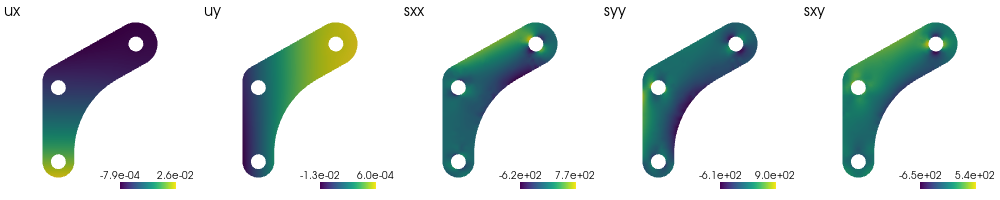

In [2]:
# load mesh and solver results
op2File = 'data/controlArm/v2.0/controlArm02.op2'
geom = MeshGeom(op2File, thickness=1.0)
plotScalarFields(geom.mesh, geom.resDf)

In [2]:
# # load using the alternative format
# meshFile = 'data/controlArm/v1.0/controlArm01_nom.vtk'
# pickleFile = 'data/controlArm/v1.0/controlArm01_nom.p'
# geom = MeshGeom(meshFile=meshFile, pickleFile=pickleFile)
# plotScalarFields(geom.mesh, geom.resDf)

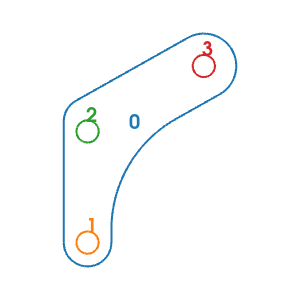

In [3]:
drawBoundaries(geom.bndDict)

Compiling model...
Building feed-forward neural network...
'build' took 0.054819 s



C:\Users\ewhalen\Miniconda3\envs\pinnDSE\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\ewhalen\Miniconda3\envs\pinnDSE\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.656560 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
0         [5.92e+02, 4.17e+02, 2.78e+05, 3.55e+04, 1.13e+05, 1.61e-06, 4.95e-06, 4.78e+02, 6.54e+02, 5.80e+03, 8.54e+02, 4.90e+03, 1.66e+02]    [6.09e+02, 4.25e+02, 2.94e+05, 3.90e+04, 1.18e+05, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 4.40e+05
  test loss: 4.51e+05
  test metric: []

'train' took 0.238360 s

Compiling model...
'compile' took 1.034233 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                            Test los

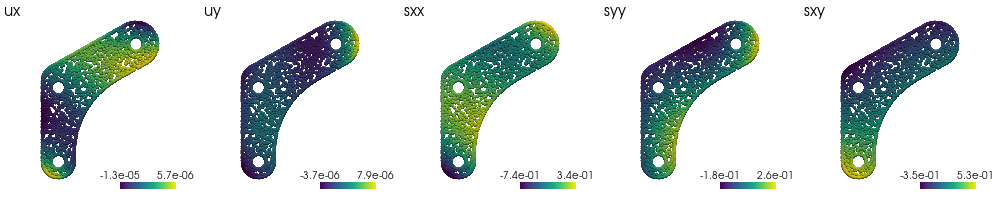

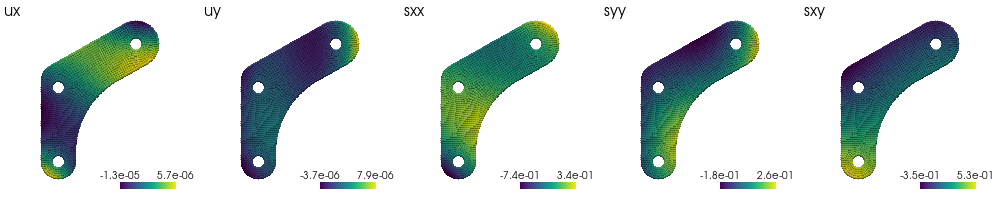

In [4]:
# supports
xBc = SupportBC(geom, bndId=3, U=0, component=0)
yBc = SupportBC(geom, bndId=3, U=0, component=1)

# traction free edges
xTr0 = TractionBC(geom, bndId=0, T=0, component=0)
yTr0 = TractionBC(geom, bndId=0, T=0, component=1)

# external loads
xTr1 = TractionBC(geom, bndId=1, T=34/geom.bndAreaDict[2], component=0)
yTr1 = TractionBC(geom, bndId=1, T=0, component=1)

xTr2 = TractionBC(geom, bndId=2, T=-34/geom.bndAreaDict[2], component=0)
yTr2 = TractionBC(geom, bndId=2, T=0, component=1)

# problem setup
bndNumSamplesDir = {0:800, 1:100, 2:100, 3:100}
paramDict = {'E':2.1e5, 'nu':0.3}
bcList = [xBc,yBc,xTr0,yTr0,xTr1,yTr1,xTr2,yTr2]
data = StrctPDE(geom, 
            elasticityEqs, 
            bcList, 
            num_domain=1000, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=500,
            paramDict=paramDict)

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# build model
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-2, 1e-2, 1e2, 1e2, 1e2]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# get the unweighted loss values
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=0)
lw = losshistory.loss_train[0]**(-1) 

# train
model.compile("adam", lr=0.001, loss_weights=lw)
losshistory, train_state = model.train(epochs=1000, display_every=100)

# test
pred = model.predict(data.train_x)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(data.train_x))
plotScalarFields(pc, predDf)

pred = model.predict(geom.mesh.points[:,:2])
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(geom.mesh.points)
plotScalarFields(pc, predDf)

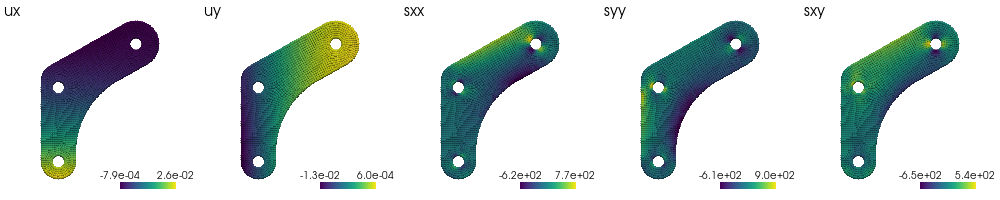

In [5]:
plotScalarFields(pc, geom.resDf)

In [6]:
bcNames = ['xBc','yBc','xTr0','yTr0','xTr1','yTr1','xTr2','yTr2']
# lines = alt.Chart(pd.DataFrame({'step':[1000,3000,4000]})).mark_rule(color='gray').encode(x='step:Q')
lossPlot(losshistory, bcNames)

alt.Chart(...)

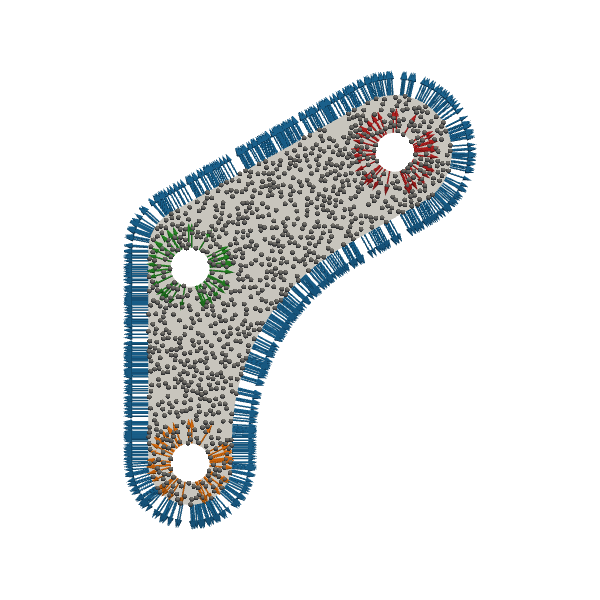

In [9]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(geom.mesh, show_edges=False)

# domain samples
pc = pv.PolyData(addZ(data.domainSamples))
plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')

# boundary samples
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'pink']
for bndId, color in zip(geom.bndDict.keys(), CATEGORY10):
    samples = addZ(data.bndSampleDict[bndId])
    normals = addZ(data.bndNormalsDict[bndId])
    plotter.add_arrows(samples, normals, 0.1, color=color)
plotter.show(window_size=(600,600), cpos='xy');